# Predicting BitCoin prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [1]:
# Change Keras backend
from keras import backend as K
import os
os.environ['KERAS_BACKEND'] = "cntk"

In [2]:
# install dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# 1. Get historic stock prices
def allData():
    path = '../datasets/BTC/'
    
    ori_df = pd.read_csv(f"{path}gemini_BTCUSD_2015_1min.csv")
    for item in range(2016, 2022):
        df = pd.read_csv(f"{path}/gemini_BTCUSD_{item}_1min.csv")
        new_df = pd.concat([ori_df, df], ignore_index=True)
        ori_df = new_df

    ori_df.rename({"Unix Timestamp": "Timestamp"}, axis=1, inplace=True)
    combine_df = ori_df
    combine_df.drop_duplicates(subset=["Timestamp"], keep='first', inplace=True)
    
    return combine_df

data = allData()

# Data review

In [4]:
data.head()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1451606340,2015-12-31 23:59:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
1,1451606280,2015-12-31 23:58:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
2,1451606220,2015-12-31 23:57:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
3,1451606160,2015-12-31 23:56:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
4,1451606100,2015-12-31 23:55:00,BTCUSD,429.95,429.95,429.95,429.95,0.0


In [5]:
data.tail()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
3050922,1609459440000,2021-01-01 00:04:00,BTCUSD,29056.21,29056.21,29046.04,29048.46,0.032502
3050923,1609459380000,2021-01-01 00:03:00,BTCUSD,29057.27,29057.27,29028.69,29056.21,0.049909
3050924,1609459320000,2021-01-01 00:02:00,BTCUSD,29085.38,29086.14,29043.25,29057.27,5.075271
3050925,1609459260000,2021-01-01 00:01:00,BTCUSD,29033.01,29086.14,29033.01,29085.38,1.451389
3050926,1609459200000,2021-01-01 00:00:00,BTCUSD,28979.74,29033.01,28956.18,29033.01,0.126441


In [6]:
data.columns

Index(['Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data = data.drop(columns=['Date', 'Symbol', 'Open', 'High', 'Low', 'Volume'])

In [8]:
data.shape

(3050927, 2)

In [9]:
data.describe()

,Timestamp,Close
count,3.050927e+06,3.050927e+06
mean,8.009380e+11,1.089529e+04
std,7.923166e+11,1.427358e+04
min,1.444312e+09,2.360000e+02
25%,1.490075e+09,1.178570e+03
50%,1.536069e+12,6.765350e+03
75%,1.586757e+12,1.042789e+04
max,1.633651e+12,6.489000e+04


In [10]:
data.dtypes

Timestamp      int64
Close        float64
dtype: object

In [11]:
data.set_index('Timestamp', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050927 entries, 1451606340 to 1609459200000
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Close   float64
dtypes: float64(1)
memory usage: 46.6 MB


In [12]:
data.sort_index(inplace=True)

In [13]:
data_close = data['Close']
data_close

Timestamp
1444311600         242.50
1444311660         242.95
1444311720         242.95
1444311780         242.96
1444311840         242.96
                   ...   
1633651200000    53841.33
1633651260000    53857.19
1633651320000    53779.86
1633651380000    53744.05
1633651440000    53823.93
Name: Close, Length: 3050927, dtype: float64

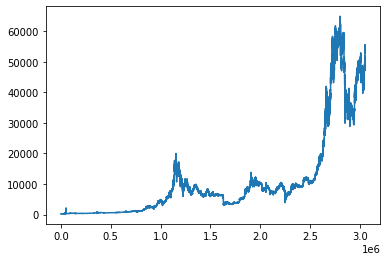

In [14]:
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))

In [16]:
data_close = scaler.fit_transform(data_close)
data_close

array([[1.00535156e-04],
       [1.07495283e-04],
       [1.07495283e-04],
       ...,
       [8.28160052e-01],
       [8.27606181e-01],
       [8.28841680e-01]])

In [17]:
# split data into train and test
train_size = int(len(data_close)*0.7)
test_size = len(data_close) - train_size

data_train, data_test = data_close[0:train_size, :], data_close[train_size:len(data_close), :]
print('Split data into train and test: ', len(data_train), len(data_test))

Split data into train and test:  2135648 915279


In [18]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 7 minutes to predict price
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(data_train, series)
testX, testY = create_ts(data_test, series)

In [19]:
trainX

array([[1.00535156e-04, 1.07495283e-04, 1.07495283e-04, ...,
        1.07649952e-04, 1.07649952e-04, 1.07649952e-04],
       [1.07495283e-04, 1.07495283e-04, 1.07649952e-04, ...,
        1.07649952e-04, 1.07649952e-04, 1.07649952e-04],
       [1.07495283e-04, 1.07649952e-04, 1.07649952e-04, ...,
        1.07649952e-04, 1.07649952e-04, 1.07649952e-04],
       ...,
       [1.12202029e-01, 1.12202029e-01, 1.12274569e-01, ...,
        1.12417484e-01, 1.12453367e-01, 1.12458935e-01],
       [1.12202029e-01, 1.12274569e-01, 1.12274569e-01, ...,
        1.12453367e-01, 1.12458935e-01, 1.12458935e-01],
       [1.12274569e-01, 1.12274569e-01, 1.12417484e-01, ...,
        1.12458935e-01, 1.12458935e-01, 1.12428929e-01]])

In [20]:
trainX[0]

array([0.00010054, 0.0001075 , 0.0001075 , 0.00010765, 0.00010765,
       0.00010765, 0.00010765])

In [21]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
# build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=1, batch_size=32)

66739/66739 [==============================] - 394s 6ms/step - loss: 1.2356e-05


In [23]:
# test the model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

# unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [24]:
# Calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 15.31358533288743
Test score: %.2f rmse 894.1935060654289


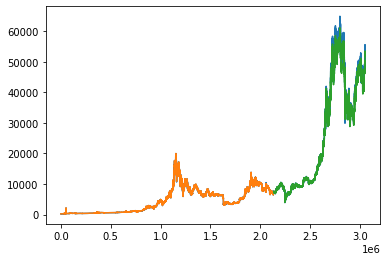

In [25]:
# Plot the predictions on a graph
train_plot = np.empty_like(data_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(data_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(data_close)-1, :] = testPredictions

plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [26]:
from datetime import datetime

dates = pd.date_range(start = datetime.today(), end = datetime(2022, 5, 3, 0, 0, 0), freq='T').tolist()
dates

[Timestamp('2022-02-03 14:17:12.933623', freq='T'),
 Timestamp('2022-02-03 14:18:12.933623', freq='T'),
 Timestamp('2022-02-03 14:19:12.933623', freq='T'),
 Timestamp('2022-02-03 14:20:12.933623', freq='T'),
 Timestamp('2022-02-03 14:21:12.933623', freq='T'),
 Timestamp('2022-02-03 14:22:12.933623', freq='T'),
 Timestamp('2022-02-03 14:23:12.933623', freq='T'),
 Timestamp('2022-02-03 14:24:12.933623', freq='T'),
 Timestamp('2022-02-03 14:25:12.933623', freq='T'),
 Timestamp('2022-02-03 14:26:12.933623', freq='T'),
 Timestamp('2022-02-03 14:27:12.933623', freq='T'),
 Timestamp('2022-02-03 14:28:12.933623', freq='T'),
 Timestamp('2022-02-03 14:29:12.933623', freq='T'),
 Timestamp('2022-02-03 14:30:12.933623', freq='T'),
 Timestamp('2022-02-03 14:31:12.933623', freq='T'),
 Timestamp('2022-02-03 14:32:12.933623', freq='T'),
 Timestamp('2022-02-03 14:33:12.933623', freq='T'),
 Timestamp('2022-02-03 14:34:12.933623', freq='T'),
 Timestamp('2022-02-03 14:35:12.933623', freq='T'),
 Timestamp('

In [27]:
len(dates)

127303

In [28]:
unix = []
for date in dates:
    unix.append(date.timestamp())
unix

[1643897832.933623,
 1643897892.933623,
 1643897952.933623,
 1643898012.933623,
 1643898072.933623,
 1643898132.933623,
 1643898192.933623,
 1643898252.933623,
 1643898312.933623,
 1643898372.933623,
 1643898432.933623,
 1643898492.933623,
 1643898552.933623,
 1643898612.933623,
 1643898672.933623,
 1643898732.933623,
 1643898792.933623,
 1643898852.933623,
 1643898912.933623,
 1643898972.933623,
 1643899032.933623,
 1643899092.933623,
 1643899152.933623,
 1643899212.933623,
 1643899272.933623,
 1643899332.933623,
 1643899392.933623,
 1643899452.933623,
 1643899512.933623,
 1643899572.933623,
 1643899632.933623,
 1643899692.933623,
 1643899752.933623,
 1643899812.933623,
 1643899872.933623,
 1643899932.933623,
 1643899992.933623,
 1643900052.933623,
 1643900112.933623,
 1643900172.933623,
 1643900232.933623,
 1643900292.933623,
 1643900352.933623,
 1643900412.933623,
 1643900472.933623,
 1643900532.933623,
 1643900592.933623,
 1643900652.933623,
 1643900712.933623,
 1643900772.933623,


In [29]:
time = []
for timestamp in unix:
    time.append(int(timestamp))
time

[1643897832,
 1643897892,
 1643897952,
 1643898012,
 1643898072,
 1643898132,
 1643898192,
 1643898252,
 1643898312,
 1643898372,
 1643898432,
 1643898492,
 1643898552,
 1643898612,
 1643898672,
 1643898732,
 1643898792,
 1643898852,
 1643898912,
 1643898972,
 1643899032,
 1643899092,
 1643899152,
 1643899212,
 1643899272,
 1643899332,
 1643899392,
 1643899452,
 1643899512,
 1643899572,
 1643899632,
 1643899692,
 1643899752,
 1643899812,
 1643899872,
 1643899932,
 1643899992,
 1643900052,
 1643900112,
 1643900172,
 1643900232,
 1643900292,
 1643900352,
 1643900412,
 1643900472,
 1643900532,
 1643900592,
 1643900652,
 1643900712,
 1643900772,
 1643900832,
 1643900892,
 1643900952,
 1643901012,
 1643901072,
 1643901132,
 1643901192,
 1643901252,
 1643901312,
 1643901372,
 1643901432,
 1643901492,
 1643901552,
 1643901612,
 1643901672,
 1643901732,
 1643901792,
 1643901852,
 1643901912,
 1643901972,
 1643902032,
 1643902092,
 1643902152,
 1643902212,
 1643902272,
 1643902332,
 1643902392,

In [30]:
unseen = pd.DataFrame(time, columns=['Timestamp'])

In [31]:
unseen

,Timestamp
0,1643897832
1,1643897892
2,1643897952
3,1643898012
4,1643898072
...,...
127298,1651535712
127299,1651535772
127300,1651535832
127301,1651535892


In [33]:
unseen.set_index('Timestamp', inplace=True)
unseen.sort_index(inplace=True)

In [35]:
data.append(unseen)

,Close
Timestamp,
1444311600,242.50
1444311660,242.95
1444311720,242.95
1444311780,242.96
1444311840,242.96
...,...
1651535712,NaN
1651535772,NaN
1651535832,NaN


In [36]:
unseenData = data.values.reshape(len(data), 1)
unseenData = scaler.fit_transform(unseenData)
unseenData

array([[1.00535156e-04],
       [1.07495283e-04],
       [1.07495283e-04],
       ...,
       [8.28160052e-01],
       [8.27606181e-01],
       [8.28841680e-01]])

In [37]:
unseenX, unseenY = create_ts(unseenData, 7)

In [38]:
unseenPredictions = model.predict(unseenX)
unseenPredictions = scaler.inverse_transform(unseenPredictions)
unseenY = scaler.inverse_transform([unseenY])

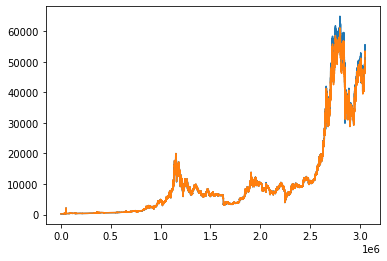

In [41]:
# Plot the predictions on a graph
unseen_plot = np.empty_like(unseenData)
unseen_plot[:,:] = np.nan
unseen_plot[7:len(unseenPredictions)+7, :] = unseenPredictions

plt.plot(scaler.inverse_transform(unseenData))
plt.plot(unseen_plot)
plt.show()